In [1]:
import searchtweets
import pandas as pd
import numpy as np
import json
import os
import requests
import time as t
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time

## Scrape tweets

Make sure there is a 'creds.yaml' file containing Twitter API credentials in the same folder as the notebook

In [ ]:
search_args = searchtweets.load_credentials(filename="./creds.yaml",
                 yaml_key="search_tweets_api_4",
                 env_overwrite=False)

Scrape tweet data from 03-11-2020 until now (which was 07-05-2020)

In [222]:
date_s = datetime(2020, 3, 11)
date_u = date_s + timedelta(days=1)
for i in range(58):
    # Query and and extra search options
    rule = searchtweets.gen_rule_payload("(covid OR uwkot OR corona OR masker OR distance OR woonzorg OR virus OR afstand OR lockdown) lang:nl place_country:BE", results_per_call=100, from_date = date_s.strftime("%Y%m%d%H%M"), to_date = date_u.strftime("%Y%m%d%H%M"))
    try:
        tweets = searchtweets.collect_results(rule,
                         max_results=500,
                         result_stream_args=search_args)
        
        # Write raw json data to file
        with open(date_s.strftime("%Y%m%d")+'.json', 'w') as file:
            for tweet in tweets:
                json.dump(tweet, file)
                file.write('\n')
        # Print some information to see progress
        print(tweets[0]['created_at'])
        print('Count: {}'.format(str(len(tweets))))
    except:
        print('Error')
    
    # Shift by one day
    date_s = date_u
    date_u = date_s + timedelta(days=1)
    
    # Sleep to avoid rate limits
    t.sleep(10)

Grabbing bearer token from OAUTH


Fri Apr 10 23:35:48 +0000 2020
Count: 22
Sat Apr 11 21:31:53 +0000 2020
Count: 27
Sun Apr 12 23:45:40 +0000 2020
Count: 36
Mon Apr 13 21:36:06 +0000 2020
Count: 31
Tue Apr 14 22:49:36 +0000 2020
Count: 29


In [131]:
# Twitter returns bbox for locations. We use this function to get coordinates of the bbox 'center'.
# Not 100% accurate but good enough for our purpose
def estimate_loc(bbox):
    return (bbox[0][0][0]+bbox[0][2][0])/2 , (bbox[0][0][1]+bbox[0][2][1])/2

In [6]:
# Column names for our dataframe
col_names = ['date', 'id', 'text', 'time', 'retweeted', 'favorite_count', 'retweet_count', 'reply_count', 'verified_user', 'location_name', 'location_lat', 'location_lon']

data = []

# Set start dates
date_s = datetime(2020, 3, 11)
date_u = date_s + timedelta(days=1)

# Go until 07-05-2020
for i in range(58):
    num = 0
    # Open the raw json data
    with open('data/'+date_s.strftime("%Y%m%d")+'.json', 'r') as file:
        for line in file:
            tweet = json.loads(line)
            text = ''
            time = t.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y')
            
            # Get the tweet location
            if tweet['place'] is not None:
                lon, lat = estimate_loc(tweet['place']['bounding_box']['coordinates'])
                place_name = tweet['place']['name']
            # If tweet has no location, add the user's location as place name
            else:
                place_name = tweet['user']['location']
                lon, lat = None, None
            # If long tweet text, check the extended tweet for the full text
            if 'extended_tweet' in tweet:
                text = tweet['extended_tweet']['full_text']
            else:
                text = tweet['text']
            
            # Write line by line to csv
            d = [[date_s.strftime("%Y%m%d"), tweet['id_str'], text, t.strftime('%H:%M:%S', time), 'retweeted_status' in tweet, tweet['favorite_count'], tweet['retweet_count'], tweet['reply_count'], tweet['user']['verified'], place_name , lat, lon]]
            df = pd.DataFrame(data=d, columns=col_names)
            df.to_csv('data/tweets.csv', mode='a', header=not os.path.exists('data/tweets.csv'))
    
    # Shift dates
    date_s = date_u
    date_u = date_s + timedelta(days=1)

# Fix indexes in csv file
df = pd.read_csv('data/tweets.csv')
df = df[['date', 'id', 'text', 'time', 'retweeted', 'favorite_count', 'retweet_count', 'reply_count', 'verified_user', 'location_name', 'location_lat', 'location_lon']]
df.to_csv('data/tweets.csv')

## Analyzing data

In [2]:
df = pd.read_csv('data/tweets.csv')

### Tweet locations

In [115]:
# Gather tweets which have coordinates
locs = df[df['location_lat'].notna()]

In [116]:
# Keep only the id and coordinates
locs_only = locs[['id','location_lat', 'location_lon']]

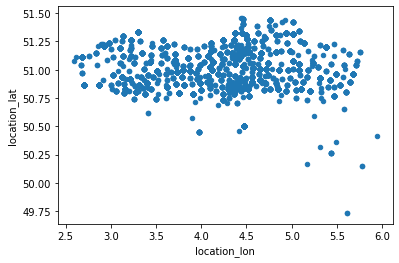

In [111]:
# Plot the data, it is clear that most tweets originated from Flanders.
# Which makes sense, as we checked for dutch tweets in Belgium
fig,ax = plt.subplots()
locs_only.plot.scatter(x='location_lon',y='location_lat',ax=ax)
plt.show()

In [136]:
# Get the tweets which do not have coordinates but do have a place name set
locs_na = df[df['location_lat'].isna()]
locs_na[locs_na['location_name'].notnull()].tail(5)

,date,id,text,time,retweeted,favorite_count,retweet_count,reply_count,verified_user,location_name,location_lat,location_lon
8321,20200507,1258371936742182916,RT @FransVerstrepe2: Het verbaast me steeds we...,12:23:43,True,0,0,0,False,"Brugge, België",NaN,NaN
8324,20200507,1258357221794160642,RT @PVANBASTELAERE: Vanaf vandaag kan je als o...,11:25:15,True,0,0,0,False,Belgium Brussels,NaN,NaN
8325,20200507,1258354913777721347,RT @VreeseMaaike: Reeds 23 000 ondernemers heb...,11:16:05,True,0,0,0,False,"Brugge, België",NaN,NaN
8335,20200507,1258323915572740096,RT @BeauVent_cv: ⚠️ Nieuwe datum ⚠️\n\n📣 Algem...,09:12:54,True,0,0,0,False,Brugge,NaN,NaN
8356,20200507,1258254122115104773,RT @FransVerstrepe2: Het verbaast me steeds we...,04:35:34,True,0,0,0,False,Limburg,NaN,NaN


In [95]:
# Use geopy with Nominatim to see if we can get some coordinates for the place names
# Only keep them if they are located in Belgium
# The users have a lot of location names like 'Anti EU' or 'Cocaine and Diamonds',
# so we do not expect to get locations for all of them
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="SentimentAnalyser/1.9")
coord = {}
def get_coordinates(city):
    print(city)
    if city not in coord:
        result = geolocator.geocode(city, addressdetails=True)
    else:
        return coord[city][0], coord[city][1]
    lat = np.NaN
    lon = np.NaN
    if result is not None:
        if 'country_code' in result.raw['address'] and result.raw['address']['country_code'] == 'be':
            lat = result.raw['lat']
            lon = result.raw['lon']
    coord[city] = (lat, lon)
    return lat,lon

In [ ]:
# Try to get the locations
new_locs = []
for index, row in locs_na[locs_na['location_name'].notnull()].iterrows():
    lat, lon = get_coordinates(row['location_name'])
    if lat != 'nan':
        new_locs.append([row.id, lat, lon])
    t.sleep(2)

In [88]:
# Put them in a dataframe and drop 'NaN' values
new_locs_df = pd.DataFrame(data=new_locs, columns=['id','location_lat', 'location_lon']).dropna().reset_index().drop('index',axis=1)

In [119]:
# See how many we got
new_locs_df.count()

id              152
location_lat    152
location_lon    152
dtype: int64

In [120]:
# Add them to the other location dataframe and write to our demo folder
locs_only = locs_only.append(new_locs_df).reset_index().drop('index',axis=1)
locs_only.to_csv('demo/data/tweet_locations.csv')

In [121]:
# Check if they were added correctly
locs_only.count()

id              8154
location_lat    8154
location_lon    8154
dtype: int64

### Tweet counts per day

In [122]:
# Group the tweets by date and keep the size as counts
tweet_count = df.groupby('date').size().reset_index(name='counts')

In [123]:
# Function to replace the date format YYYYMMDD to YYYY-MM-DD so we can use it in JavaScript
def replace_date(row):
    row['date'] = str(row['date'])[0:4]+'-'+str(row['date'])[4:6]+'-'+str(row['date'])[6:8]
    return row

In [124]:
# Replace dates with JavaScript format and write to demo folder
tweet_count = tweet_count.apply(lambda x: replace_date(x), axis=1)
tweet_count.head(5)
tweet_count.to_csv('demo/data/tweets_per_day.csv')

### Keyword count

In [126]:
# Keywords we used in our query
keywords = ['corona', 'covid', 'mondmasker', 'blijfinuwkot', 'lockdown', 'virus', 'woonzorg', 'afstand', 'distancing']

In [127]:
# For every keyword, get the amount of tweets which contain this keyword
keyword_count = []
for keyword in keywords:
    count = df[df['text'].str.contains(keyword)].count()['id']
    keyword_count.append([keyword, count])

In [128]:
keyword_count

[['corona', 2665],
 ['covid', 326],
 ['mondmasker', 219],
 ['blijfinuwkot', 260],
 ['lockdown', 1379],
 ['virus', 1351],
 ['woonzorg', 38],
 ['afstand', 678],
 ['distancing', 57]]

In [129]:
# Convert to dataframe
df_keywords = pd.DataFrame(data=keyword_count, columns=['keyword', 'count'])

In [130]:
# Write to the demo folder
df_keywords.to_csv('demo/data/keyword_count.csv')

### Most popular tweets

In [24]:
most_popular = df[['favorite_count', 'retweet_count', 'reply_count']].sum(axis=1).sort_values(ascending=False).head(5)
most_popular.index

Int64Index([1250, 964, 2040, 5450, 5995], dtype='int64')

In [31]:
most_popular_df = df.loc[most_popular.index].reset_index()[['text', 'favorite_count','retweet_count', 'reply_count']]

In [32]:
most_popular_df

,text,favorite_count,retweet_count,reply_count
0,Heel deze corona crisis heeft mij één ding gel...,6367,1485,61
1,"Ik heb daarnet met wat water, peper en zeep aa...",2835,741,33
2,We mogen nog steeds buiten om te sporten. Dit ...,2601,569,38
3,de eerste dag na de lockdown https://t.co/Fu4V...,1919,869,2
4,Stappenplan voor mensen die de festivals gaan ...,1563,293,47


In [34]:
most_popular_df.to_csv('demo/data/most_popular_tweets.csv')

In [35]:
for index, tweet in most_popular_df.iterrows():
    print(tweet.text)

Heel deze corona crisis heeft mij één ding geleerd. Ik hoop dat ik nooit een oorlog moet meemaken met dit volk.
Ik heb daarnet met wat water, peper en zeep aan mijn kinderen uitgelegd waarom we - om het #corona virus tegen te gaan - onze handen vaak moeten wassen: https://t.co/lHlRtcZMbh
We mogen nog steeds buiten om te sporten. Dit is een groot verschil met andere landen. Verkloot dit niet en hou je aan de regels. Ga max met 2 sporten. Hou afstand. Wees voorzichtig, neem geen risico’s (nu is niet het moment om een blessure op te lopen).
de eerste dag na de lockdown https://t.co/Fu4VtYeZaf
Stappenplan voor mensen die de festivals gaan missen:

1. Parkeer je auto 5km van thuis.
2. Wandel terug.
3. Koop bij de nachtwinkel 10 blikken bier voor 30 euro.
4. Speel een concertvideo af op je telefoon.
5. Bekijk die van 3 meter afstand.
6. Slaap in tuin.
7. Haal je auto op.
